In [1]:
%env CUDA_VISIBLE_DEVICES=0
import os
import math
import h5py
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import pandas as pd
from tqdm import tqdm

import random
import torch
import torch.utils.data
import torch.nn.functional as F
import torchkbnufft
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt
from k_space_reconstruction.nets.unet import Unet
from optimize_pattern import mrisensesim, ACDCDataset

import sys
sys.path.append('./pytorch_nufft')
import nufft

torch.manual_seed(228)
random.seed(228)
np.random.seed(228)


def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        


@torch.no_grad()
def test_sampling_pattern(pattern, model, val_generator, ncoils=1, coil_width=16, device=torch.device('cpu')):
    # Get image sizes
    tmp_data = next(iter(val_generator))
    size_x, size_y = tmp_data['img'].shape[-2:]
    # Prepare coil sensitivity maps
    if ncoils > 1:
        smap = torch.from_numpy(
            np.stack(mrisensesim((size_x, size_y), ncoils=ncoils, coil_width=coil_width))
        ).transpose(-1, -2).abs().float().to(device)
        grid = torch.stack(
            torch.meshgrid(torch.linspace(-math.pi, math.pi, size_x), torch.linspace(-math.pi, math.pi, size_x))
        ).flatten(1).to(device)
    nufft_ob = torchkbnufft.KbNufft(im_size=(size_x, size_y), grid_size=(size_x, size_y), device=device)
    # Eval scores
    dice_scores = []
    for data in val_generator:
        if ncoils > 1:
            ks = Ft(data['img'] * data['std'] + data['mean'])
            kdata = nufft_ob(IFt(ks).abs().cfloat().to(device), grid, smaps=smap.cfloat())
            ks = kdata.reshape(ks.shape[0], ncoils, *ks.shape[-2:])
            simg = IFt(ks * pattern).abs().square().mean(1).sqrt()[:, None]
        else:
            ks = Ft(data['img'] * data['std'] + data['mean'])
            simg = IFt(ks * pattern).abs()
        s, m = torch.std_mean(simg, dim=[-2, -1])
        simg = (simg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(1 - dice_loss(gt[i][None], pm[i][None]).item())
    return dice_scores

@torch.no_grad()
def _test_sampling_grid(grid, model, val_generator, device=torch.device('cpu'), oshape=[256, 16], ishape=[256, 256]):
    dice_scores = []
    for data in val_generator:
        img = data['img'] * data['std'] + data['mean']
        ks = nufft.nufft(img.cuda(), grid.T, device='cuda').reshape(img.shape[0], img.shape[1], *oshape)
        rimg = nufft.nufft_adjoint(ks, grid.T, out_shape=(img.shape[0], img.shape[1], *ishape), device='cuda').abs()
        s, m = torch.std_mean(rimg, dim=[-2, -1])
        rimg = (rimg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)
        pm = model(rimg)
        gt = data['mask'].long()
        for i in range(rimg.shape[0]):
            dice_scores.append(1 - dice_loss(gt[i][None], pm[i][None]).item())
    return dice_scores

env: CUDA_VISIBLE_DEVICES=0


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/train.h5', device)
val_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/val.h5', device)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('./models/unet-acdc-norot.pt'))

<All keys matched successfully>

In [3]:
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(16)//2 : 256//2 + int(16)//2] = 1
fm = torch.ones(256).cuda().float()

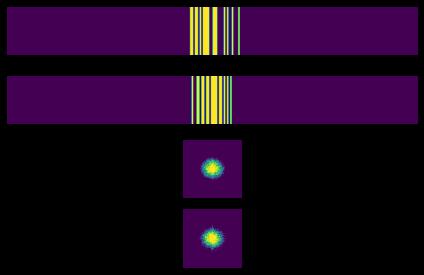

In [4]:
lp_1d_1c = torch.load('patterns/loupe_16_1d_1coils_acdc.pt').to(device)
pl_1d_1c = torch.load('patterns/pilot_16_1d_1coils_acdc.pt').to(device)
lp_1d_15c = torch.load('patterns/loupe_16_1d_15coils_acdc.pt').to(device)
lp_2d_1c = torch.load('patterns/loupe_16_2d_1coils_acdc.pt').to(device)
lp_2d_15c = torch.load('patterns/loupe_16_2d_15coils_acdc.pt').to(device)

plt.subplot(411)
plt.imshow(lp_1d_1c.repeat(30,1).cpu())
plt.axis('off')
plt.subplot(412)
plt.imshow(pl_1d_1c.repeat(30,1).cpu())
plt.axis('off')
plt.subplot(413)
plt.imshow(lp_2d_1c.cpu())
plt.axis('off')
plt.subplot(414)
plt.imshow(lp_2d_15c.cpu())
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
dice_scores = dict(
    zp_1d_1c=test_sampling_pattern(zm[None,None,:,None], model, val_generator, ncoils=1, device=device),
    lp_1d_1c=test_sampling_pattern(lp_1d_1c[None,None,:,None], model, val_generator, ncoils=1, device=device), 
    pl_1d_1c=test_sampling_pattern(pl_1d_1c[None,None,:,None], model, val_generator, ncoils=1, device=device), 
    pl_1d_1c_nu=_test_sampling_grid(torch.load('./pilot_grid.pt').cuda(), model, val_generator, device=device),
    full_1c=test_sampling_pattern(fm, model, val_generator, ncoils=1, device=device),
)

df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,zp_1d_1c,lp_1d_1c,pl_1d_1c,pl_1d_1c_nu,full_1c
count,514.000000,514.000000,514.000000,514.000000,514.000000
mean,0.662227,0.727321,0.631695,0.707802,0.842020
std,0.226380,0.210657,0.234562,0.208857,0.177508
min,0.246391,0.244046,0.243943,0.245643,0.247364
25%,0.520321,0.617501,0.437046,0.595065,0.837785
50%,0.752468,0.829259,0.687737,0.810950,0.924123
75%,0.850872,0.887094,0.843328,0.875431,0.945338
max,0.915913,0.946137,0.931876,0.922222,0.970494


In [6]:
import sys
sys.path.append('./pytorch_nufft')
import nufft

grid = torch.load('./pilot_d_grid.pt').cuda()
dcf = (grid[0]**2 + grid[1]**2)**0.2

def get_grid(xcor, ycor):
    X, Y = torch.meshgrid([xcor, ycor])
    grid = torch.stack([X.flatten(), Y.flatten()])
    return grid

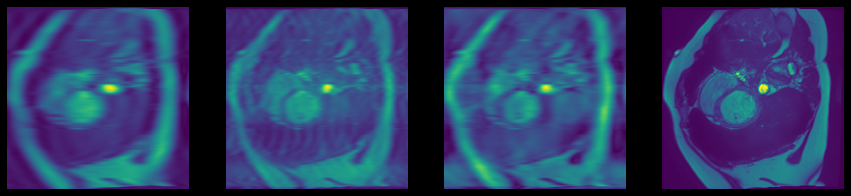

In [9]:
plt.figure(figsize=(15,10))

data = val_dataset[0]
# ks = Ft(data['img'] * data['std'] + data['mean'])
# simg = IFt(ks * zm).abs()
grid = get_grid(torch.arange(-128,128), torch.arange(-128, 128)[zm == 1]).cuda()
img = data['img'] * data['std'] + data['mean']
ks = nufft.nufft(img, grid.T, device='cuda').reshape(1, 256, 16)
simg = nufft.nufft_adjoint(ks, grid.T, out_shape=img.shape, device='cuda').abs()

plt.subplot(141)
plt.imshow(simg[0].cpu())
plt.axis('off')

# ks = Ft(data['img'] * data['std'] + data['mean'])
# simg = IFt(ks * lp_1d_1c).abs()
grid = get_grid(torch.arange(-128,128), torch.arange(-128, 128)[lp_1d_1c == 1]).cuda()
img = data['img'] * data['std'] + data['mean']
ks = nufft.nufft(img, grid.T, device='cuda').reshape(1, 256, 16)
simg = nufft.nufft_adjoint(ks, grid.T, out_shape=img.shape, device='cuda').abs()

plt.subplot(142)
plt.imshow(simg[0].cpu())
plt.axis('off')

grid = get_grid(torch.arange(-128,128), torch.arange(-128, 128)[pl_1d_1c == 1]).cuda()
# grid = torch.load('./pilot_d_grid.pt').cuda()
img = data['img'] * data['std'] + data['mean']
ks = nufft.nufft(img, grid.T, device='cuda').reshape(1, 256, 16)
# grid = torch.load('./pilot_d_grid.pt').cuda()
simg = nufft.nufft_adjoint(ks, grid.T, out_shape=img.shape, device='cuda').abs()

plt.subplot(143)
plt.imshow(simg[0].cpu())
plt.axis('off')

plt.subplot(144)
plt.imshow(img[0].cpu())
plt.axis('off')
plt.show()

In [5]:
dice_scores = dict(
    zp_1d_1c=test_sampling_pattern(zm[None, None, :, None], model, val_generator, ncoils=1, device=device),
    zp_1d_15c=test_sampling_pattern(zm[None, None, :, None], model, val_generator, ncoils=15, device=device),
    lp_1d_1c=test_sampling_pattern(lp_1d_1c[None, None, :, None], model, val_generator, ncoils=1, device=device), 
    lp_1d_15c=test_sampling_pattern(lp_1d_15c[None, None, :, None], model, val_generator, ncoils=15, device=device), 
    lp_2d_1c=test_sampling_pattern(lp_2d_1c[None, None], model, val_generator, ncoils=1, device=device), 
    lp_2d_15c=test_sampling_pattern(lp_2d_15c[None, None], model, val_generator, ncoils=15, device=device), 
    full_1c=test_sampling_pattern(fm, model, val_generator, ncoils=1, device=device),
    full_15c=test_sampling_pattern(fm, model, val_generator, ncoils=15, device=device),
)

df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,zp_1d_1c,zp_1d_15c,lp_1d_1c,lp_1d_15c,lp_2d_1c,lp_2d_15c,full_1c,full_15c
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,0.662227,0.440390,0.727321,0.510898,0.806935,0.658551,0.842020,0.666654
std,0.226380,0.194275,0.210657,0.216682,0.184453,0.222615,0.177508,0.231103
min,0.246391,0.239404,0.244046,0.242357,0.247248,0.245674,0.247364,0.243264
25%,0.520321,0.248725,0.617501,0.259580,0.716621,0.519088,0.837785,0.496901
50%,0.752468,0.413819,0.829259,0.499001,0.895168,0.696689,0.924123,0.713616
75%,0.850872,0.580847,0.887094,0.704799,0.925801,0.859821,0.945338,0.869362
max,0.915913,0.885821,0.946137,0.918525,0.961389,0.953597,0.970494,0.970221


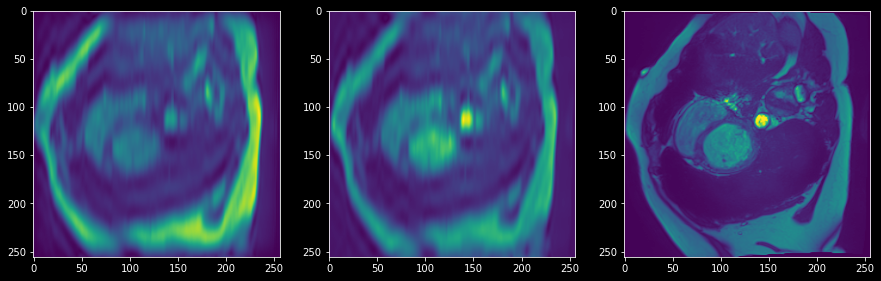

In [7]:
ncoils = 15

tmp_data = val_dataset[0]
size_x, size_y = tmp_data['img'].shape[-2:]
smap = torch.from_numpy(
    np.stack(mrisensesim((size_x, size_y), ncoils=ncoils, coil_width=16))
).transpose(-1, -2).abs().float().to(device)
grid = torch.stack(
    torch.meshgrid(torch.linspace(-math.pi, math.pi, size_x), torch.linspace(-math.pi, math.pi, size_x))
).flatten(1).to(device)
nufft_ob = torchkbnufft.KbNufft(im_size=(size_x, size_y), grid_size=(size_x, size_y), device=device)

data = val_dataset[0]

ks = Ft(data['img'] * data['std'] + data['mean'])[None]
kdata = nufft_ob(IFt(ks).abs().cfloat(), grid, smaps=smap.cfloat())
ks = kdata.reshape(ks.shape[0], ncoils, *ks.shape[-2:])
csimg = IFt(ks * zm[None, None, :, None]).abs().square().mean(1).sqrt()[:, None]
csimg = (csimg - csimg.mean([1,2,3])) / (csimg.std([1,2,3]) + 1e-11)

ks = Ft(data['img'] * data['std'] + data['mean'])[None]
simg = IFt(ks * zm[None, None, :, None]).abs()
simg = (simg - simg.mean([1,2,3])) / (simg.std([1,2,3]) + 1e-11)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(csimg[0,0].cpu())
plt.subplot(132)
plt.imshow(simg[0,0].cpu())
plt.subplot(133)
plt.imshow(data['img'][0].cpu())
plt.show()